Loaded shape: (208, 61)


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,Y
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R


Label mapping: {'M': 0, 'R': 1}
Saved scaler to: C:\Users\abhin\sonar_retrain_outputs\scaler.pkl
Class weights: {0: 0.9325842696629213, 1: 1.077922077922078}
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4650 - loss: 0.7695 - val_accuracy: 0.3333 - val_loss: 0.7859
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5732 - loss: 0.6823 - val_accuracy: 0.4444 - val_loss: 0.7150
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6815 - loss: 0.6201 - val_accuracy: 0.6667 - val_loss: 0.6622
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7516 - loss: 0.5726 - val_accuracy: 0.6667 - val_loss: 0.6244
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7707 - loss: 0.5341 - val_accuracy: 0.6667 - val_loss: 0.5963
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8153 - loss: 0.5016 - val_accuracy: 0.6667 - val_loss: 0.5758
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8408 - loss: 0.

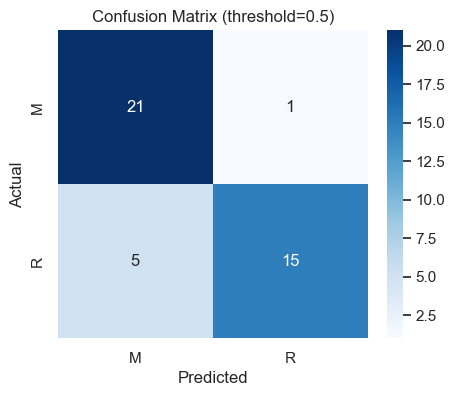

ROC-AUC: 0.9386


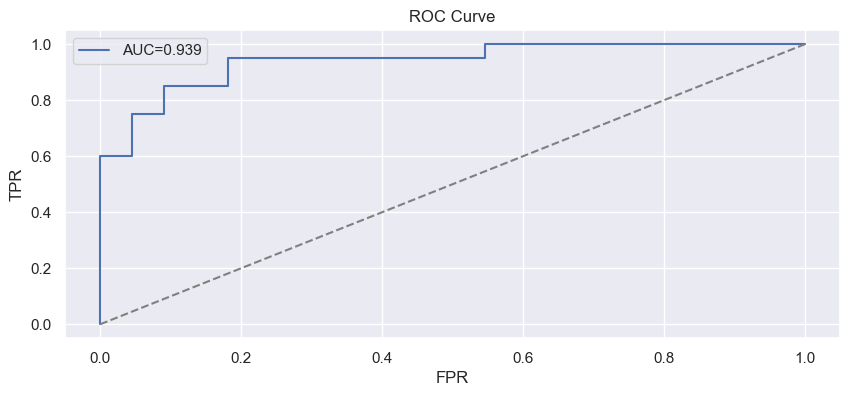


Best threshold by macro-F1: 0.140 (macro-precision=0.887, macro-recall=0.884, macro-F1=0.881)

Classification report (best threshold):

              precision    recall  f1-score   support

           M       0.95      0.82      0.88        22
           R       0.83      0.95      0.88        20

    accuracy                           0.88        42
   macro avg       0.89      0.88      0.88        42
weighted avg       0.89      0.88      0.88        42



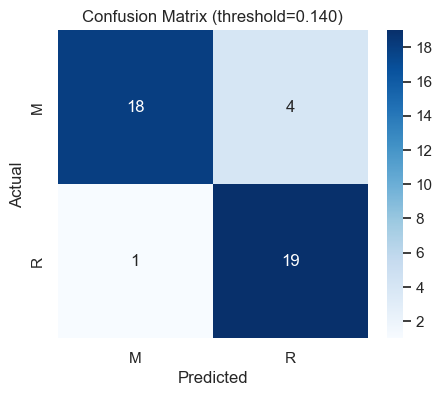

Saved model (native Keras) to: C:\Users\abhin\sonar_retrain_outputs\sonar_model_retrained.keras

All done — outputs saved in folder: C:\Users\abhin\sonar_retrain_outputs


In [5]:
# ----------------------------
# SONAR model with class weights, evaluate.
# ----------------------------
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# ---------- CONFIG ----------
DATA_PATH = r"C:\Users\abhin\Downloads\sonardataset (2).csv"
FALLBACK = r"/mnt/data/sonardataset (2).csv"
OUT_DIR = Path("sonar_retrain_outputs")
OUT_DIR.mkdir(exist_ok=True)

# Best params from your search (used to rebuild & retrain)
BEST_PARAMS = {
    "n_neurons": 64,
    "dropout": 0.0,
    "lr": 5e-4,
    "optimizer": "adam",
    "batch_size": 16,
    "epochs": 50
}

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------- Load & clean ----------
if not Path(DATA_PATH).exists():
    if Path(FALLBACK).exists():
        DATA_PATH = FALLBACK
        print("Using fallback path:", FALLBACK)
    else:
        raise FileNotFoundError(f"CSV not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
display(df.head(3))

# assume last column is label
label_col = df.columns[-1]
feature_df = df.drop(columns=[label_col])

# coerce numeric, drop fully non-numeric columns, fill medians
numeric_df = feature_df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all').fillna(method='ffill').fillna(method='bfill')
# if still NaNs, fill with median
numeric_df = numeric_df.fillna(numeric_df.median())

X = numeric_df.values.astype(float)
y_raw = df[label_col].astype(str).values

le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------- Train/test split & scaling ----------
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)
# we'll train with class weights on X_train_full
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

joblib.dump(scaler, OUT_DIR/"scaler.pkl")
print("Saved scaler to:", (OUT_DIR/"scaler.pkl").resolve())

# ---------- compute class weights ----------
cw_values = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_full), y=y_train_full)
class_weights = {i: float(cw_values[i]) for i in range(len(cw_values))}
print("Class weights:", class_weights)

# ---------- model factory (warning-free: use Input implicitly via shape) ----------
def build_model(input_dim, n_neurons=32, dropout_rate=0.2, lr=1e-3, optimizer='adam'):
    model = Sequential()
    # Input layer (avoid Dense(input_shape=...))
    model.add(tf.keras.Input(shape=(input_dim,)))
    model.add(Dense(n_neurons, activation='relu'))
    if dropout_rate and dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(max(8, n_neurons//2), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=lr) if optimizer=='adam' else RMSprop(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# ---------- rebuild & retrain on full train with class weights ----------
model = build_model(input_dim=X_train_full.shape[1],
                    n_neurons=BEST_PARAMS['n_neurons'],
                    dropout_rate=BEST_PARAMS['dropout'],
                    lr=BEST_PARAMS['lr'],
                    optimizer=BEST_PARAMS['optimizer'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# use small validation split from train for early stopping
history = model.fit(
    X_train_full, y_train_full,
    validation_split=0.05,
    epochs=BEST_PARAMS['epochs'],
    batch_size=BEST_PARAMS['batch_size'],
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)

# ---------- Evaluate on test ----------
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification report (threshold=0.5):\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (threshold=0.5)'); plt.show()

# ROC & AUC (binary)
if len(np.unique(y_test))==2:
    auc = roc_auc_score(y_test, y_prob)
    print("ROC-AUC:", round(auc,4))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(); plt.plot(fpr, tpr, label=f'AUC={auc:.3f}'); plt.plot([0,1],[0,1],'--', color='gray'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# ---------- Threshold tuning: find threshold that maximizes macro F1 ----------
thresholds = np.linspace(0.1, 0.9, 81)
best_t = 0.5
best_f1 = -1
best_stats = None
for t in thresholds:
    y_t = (y_prob >= t).astype(int)
    p,r,f,_ = precision_recall_fscore_support(y_test, y_t, average='macro', zero_division=0)
    if f > best_f1:
        best_f1 = f
        best_t = t
        best_stats = (p,r,f)
print(f"\nBest threshold by macro-F1: {best_t:.3f} (macro-precision={best_stats[0]:.3f}, macro-recall={best_stats[1]:.3f}, macro-F1={best_stats[2]:.3f})")

# show confusion at best threshold
y_best = (y_prob >= best_t).astype(int)
print("\nClassification report (best threshold):\n")
print(classification_report(y_test, y_best, target_names=le.classes_))
cm2 = confusion_matrix(y_test, y_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'Confusion Matrix (threshold={best_t:.3f})'); plt.show()

# ---------- Save model (native Keras format .keras) ----------
save_path = OUT_DIR / "sonar_model_retrained.keras"
try:
    model.save(save_path)
    print("Saved model (native Keras) to:", save_path.resolve())
except Exception as e:
    # fallback to h5 if .keras not supported (older TF)
    h5_path = OUT_DIR / "sonar_model_retrained.h5"
    model.save(h5_path)
    print("Saved model to (h5):", h5_path.resolve())

print("\nAll done — outputs saved in folder:", OUT_DIR.resolve())


In [ ]:
# =========================
# Reproduce Sonar experiments (angle-independent series)
# =========================
%matplotlib inline
import os
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import time

# ---------------- CONFIG ----------------
DATA_PATH = r"C:\Users\abhin\Downloads\sonardataset (2).csv"  # change if needed
FALLBACK = r"/mnt/data/sonardataset (2).csv"
HIDDEN_UNITS = [0, 2, 3, 6, 12, 24]
EPOCHS = 300                    # as in the paper
BATCH_SIZE = None               # "entire training set" -> we'll use full-batch if possible; else set None
REPEATS = 3                     # paper used 10; set 10 for exact replication (longer)
VERBOSE = 0                     # set to 1 to see per-epoch progress
RANDOM_SEED = 42

# safety checks for path
path = Path(DATA_PATH) if Path(DATA_PATH).exists() else (Path(FALLBACK) if Path(FALLBACK).exists() else None)
if path is None:
    raise FileNotFoundError(f"Data file not found. Update DATA_PATH. Tried: {DATA_PATH} and {FALLBACK}")
print("Using dataset:", path)

# ---------------- Load & prepare ----------------
df = pd.read_csv(path)
print("Loaded shape:", df.shape)
# assume last column is label, rest features (first 60 features expected)
features = df.columns[:-1]
label_col = df.columns[-1]
X = df[features].apply(pd.to_numeric, errors='coerce').values.astype(np.float32)
y_raw = df[label_col].astype(str).values
le = LabelEncoder()
y = le.fit_transform(y_raw)  # 0/1 mapping
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
n_samples, n_features = X.shape
print("Samples:", n_samples, "Features:", n_features)

# If BATCH_SIZE is None we will use full-batch (i.e. batch_size = n_train) to mimic "epochs over whole set"
def build_model(hidden_units, input_dim):
    model = Sequential()
    if hidden_units == 0:
        # direct linear layer to 2 outputs (paper used 2 outputs). We'll use softmax over 2 units.
        model.add(tf.keras.Input(shape=(input_dim,)))
        model.add(Dense(2, activation='softmax'))
    else:
        model.add(tf.keras.Input(shape=(input_dim,)))
        model.add(Dense(hidden_units, activation='tanh'))   # paper used classic activations; tanh is reasonable
        model.add(Dense(2, activation='softmax'))
    # SGD with lr=2.0, momentum=0.0 (as paper)
    opt = SGD(learning_rate=2.0, momentum=0.0)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ---------------- 13-fold splitting function ----------------
def make_13_folds_indices(n, rng):
    # create random permutation of indices and split into 13 roughly equal parts
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, 13)
    return folds

# ---------------- run experiments ----------------
results = {}  # dict: hidden_units -> list of (train_acc, test_acc) across repeats & folds
rng = np.random.RandomState(RANDOM_SEED)

for h in HIDDEN_UNITS:
    results[h] = {'train_acc': [], 'test_acc': []}

total_start = time.time()
for rep in range(REPEATS):
    print(f"\n=== REPEAT {rep+1}/{REPEATS} ===")
    folds = make_13_folds_indices(n_samples, rng)
    for fold_idx, test_idx in enumerate(folds):
        # construct train indices as all except this fold
        train_idx = np.hstack([f for i,f in enumerate(folds) if i != fold_idx])
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # set batch_size: full-batch to mimic "one epoch = pass over whole training set"
        batch_size = X_train.shape[0] if BATCH_SIZE is None else BATCH_SIZE

        for h in HIDDEN_UNITS:
            # build fresh model
            model = build_model(h, input_dim=n_features)
            # fit model
            # use shuffle=False to mimic deterministic epoch behavior per original experiments
            model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, verbose=VERBOSE, shuffle=False)
            # evaluate on train and test
            tr_loss, tr_acc = model.evaluate(X_train, y_train, verbose=0)
            te_loss, te_acc = model.evaluate(X_test, y_test, verbose=0)
            results[h]['train_acc'].append(tr_acc)
            results[h]['test_acc'].append(te_acc)
        # end for hidden units
        if (fold_idx+1) % 4 == 0:
            print(f"  Completed fold {fold_idx+1}/13")
    # end folds
# end repeats
total_time = time.time() - total_start
print(f"\nAll experiments finished in {total_time:.1f}s")

# ---------------- summarize ----------------
summary = []
for h in HIDDEN_UNITS:
    train_arr = np.array(results[h]['train_acc'])
    test_arr = np.array(results[h]['test_acc'])
    summary.append({
        'hidden_units': h,
        'train_mean': train_arr.mean(),
        'train_std': train_arr.std(ddof=1),
        'test_mean': test_arr.mean(),
        'test_std': test_arr.std(ddof=1),
        'n_runs': len(train_arr)
    })

summary_df = pd.DataFrame(summary).sort_values('hidden_units')
pd.set_option('display.precision', 4)
print("\n===== Summary (means ± std) =====")
display(summary_df)

# ---------------- print nicely ----------------
print("\nReadable results:")
for row in summary:
    print(f"Hidden={row['hidden_units']:2d} | Train: {row['train_mean']*100:5.2f}% ± {row['train_std']*100:5.2f}%"
          f" | Test: {row['test_mean']*100:5.2f}% ± {row['test_std']*100:5.2f}% (n={row['n_runs']})")


Using dataset: C:\Users\abhin\Downloads\sonardataset (2).csv
Loaded shape: (208, 61)
Label mapping: {'M': 0, 'R': 1}
Samples: 208 Features: 60

=== REPEAT 1/3 ===
